# Binary classificator for pertinent sentences
Built with Keras and Tensorflow

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import sklearn
import sys
import pickle
import transformers
import os
from sklearn.model_selection import train_test_split
import datasets
from datasets import load_dataset

2023-10-23 15:38:22.339636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 15:38:23.206437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# if cuda is present but 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Dataset Import
The dataset are already splitted and provided in Hugging Face format. It could be imported with:

In [3]:
data_files = {
	"train": "data/detection-ds-train.parquet",
	"valid": "data/detection-ds-valid.parquet",
	"test": "data/detection-ds-test.parquet"
}

ds = load_dataset("parquet", data_files=data_files)
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3031
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 649
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 650
    })
})

## Model Building
The checkpoint is bert-base-uncased


In [4]:
from transformers import AutoTokenizer, TFBertModel
# Get BERT layer
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert_tf= TFBertModel.from_pretrained(checkpoint, trainable=False)

2023-10-23 15:38:28.331944: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-23 15:38:28.332039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: d4idalos-X580VN
2023-10-23 15:38:28.332059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: d4idalos-X580VN
2023-10-23 15:38:28.332316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.104.5
2023-10-23 15:38:28.332376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.104.5
2023-10-23 15:38:28.332392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.104.5
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.prediction

In [5]:
def tokenize (batch):
    return tokenizer(batch["text"], max_length=512, padding='max_length', truncation=True, return_tensors="tf")

In [6]:
ds_encoded = ds.map(tokenize, batched= True, batch_size= None)
print(ds_encoded["train"].column_names)

Map:   0%|          | 0/649 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


In [7]:
X_tf_train = [tokenizer(text, padding="max_length",max_length = 512, truncation=True)['input_ids'] for text in ds_encoded["train"]['text']]
X_tf_train = np.array(X_tf_train, dtype='int32')

In [8]:
X_tf_valid = [tokenizer(text, padding="max_length",max_length = 512, truncation=True)['input_ids'] for text in ds_encoded["valid"]['text']]
X_tf_valid = np.array(X_tf_valid, dtype='int32')

In [9]:

y_tf_train = ds_encoded["train"]["label"]
y_tf_valid = ds_encoded["valid"]["label"]

y_tf_train = np.array(y_tf_train)
y_tf_valid = np.array(y_tf_valid)

In [10]:
y_tf_train

array([1, 0, 1, ..., 1, 1, 0])

Utilizzeremo a dispetto del precedente Notebook i tensori dati dagli array NumPy e quindi non quelli di Tensorflow. Questa è una feature di tensorflow che Pytorch non possiede.
La prima cosa da fare dunque è quella di convertire gli input in Array NumPy utilizzando il tokenizer

## Costruzione del modello
Passiamo alla costruzione vera e propria del modello, la prima cosa da fare è quella di prendere il layer BERT dalla libreria trasformer

In [11]:
# Let's create a sample of size 5 from the training data
sample = X_tf_train[0:5]
print('Object type: ', type(bert_tf(sample)))
print('Output format (shape): ',bert_tf(sample)[0].shape)
print('Output used as input for the classifier (shape): ', bert_tf(sample)[0][:,0,:].shape)


Object type:  <class 'transformers.modeling_tf_outputs.TFBaseModelOutputWithPoolingAndCrossAttentions'>
Output format (shape):  (5, 512, 768)
Output used as input for the classifier (shape):  (5, 768)


In [15]:
from keras import models, layers, metrics
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

input_ids_in = layers.Input(shape=(512,), name='input_token', dtype='int32')

x = bert_tf(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.3, name='dropout')(x)
#x = layers.Dense(768, activation='relu', name='pre-classifier')(x)
x = layers.Dense(1, activation='sigmoid', name='classification')(x)

model_tf = models.Model(inputs=input_ids_in, outputs = x, name='BinaryClassificator')

model_tf.compile(loss="binary_crossentropy", optimizer="adam",metrics=METRICS)

model_tf.summary()


Model: "BinaryClassificator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 512)]             0         
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   109482240 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 512, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                       
                                               

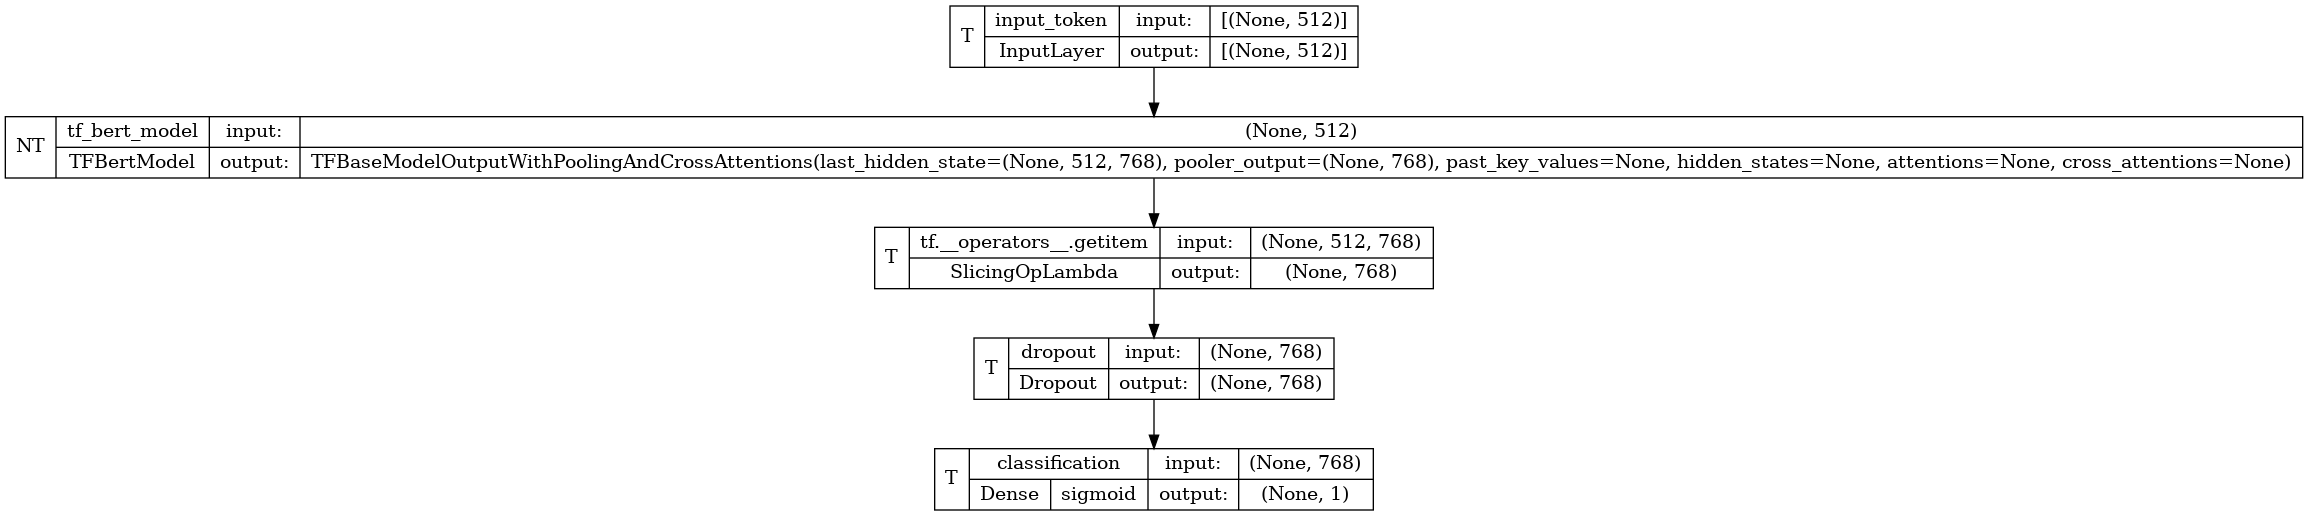

In [13]:
tf.keras.utils.plot_model(
    model_tf,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    show_layer_activations=True,
    show_trainable=True,
)

In [16]:
from datetime import datetime
# Train the model
start_time = datetime.now()
history = model_tf.fit(X_tf_train, y_tf_train, batch_size=32, shuffle=True, epochs=3, validation_data=(X_tf_valid, y_tf_valid))
end_time = datetime.now()

Epoch 1/3
95/95 [==============================] - 3045s 32s/step - loss: 0.6894 - accuracy: 0.5563 - precision: 0.5477 - recall: 0.5693 - val_loss: 0.5758 - val_accuracy: 0.6533 - val_precision: 0.5967 - val_recall: 0.9818
Epoch 2/3
95/95 [==============================] - 3001s 32s/step - loss: 0.6227 - accuracy: 0.6354 - precision: 0.6202 - recall: 0.6705 - val_loss: 0.5345 - val_accuracy: 0.8336 - val_precision: 0.9205 - val_recall: 0.7364
Epoch 3/3
95/95 [==============================] - 2982s 31s/step - loss: 0.5830 - accuracy: 0.6777 - precision: 0.6633 - recall: 0.7019 - val_loss: 0.4892 - val_accuracy: 0.8675 - val_precision: 0.8408 - val_recall: 0.9121


In [17]:

model_tf.save('output/detector-bert.keras')

/home/d4idalos/.local/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [18]:

from sklearn.metrics import confusion_matrix

y_prediction = model_tf.predict(ds_encoded['test']['input_ids'])

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(ds_encoded['test']['label'], y_prediction)


21/21 [==============================] - 468s 22s/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
y_prediction

In [27]:
y_prediction
threshold = 0.5

# Convert probabilities to binary predictions
y_pred_binary = np.where(y_prediction >= threshold, 1, 0)
result = confusion_matrix(ds_encoded['test']['label'], y_pred_binary )
result

array([[261,  47],
       [ 21, 321]])

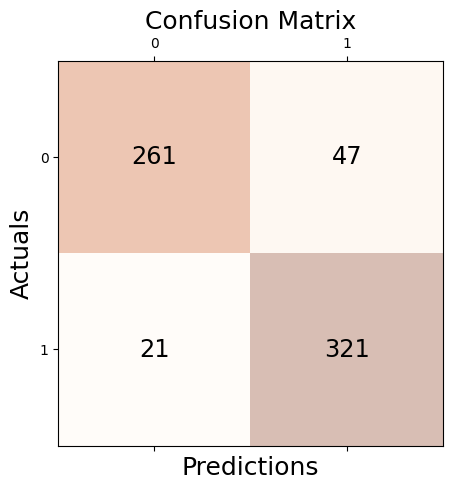

In [28]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(result, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        ax.text(x=j, y=i,s=result[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()


In [31]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
print("Metrics on test dataset:")
print("precision: \t",precision_score(ds_encoded['test']['label'], y_pred_binary))
print("recall: \t",recall_score(ds_encoded['test']['label'], y_pred_binary))
print("accuracy: \t",accuracy_score(ds_encoded['test']['label'], y_pred_binary))
print("f1-score: \t",f1_score(ds_encoded['test']['label'], y_pred_binary))

Metriche dal dataset di test:
precision: 	 0.8722826086956522
recall: 	 0.9385964912280702
accuracy: 	 0.8953846153846153
f1-score: 	 0.904225352112676


In [ ]:
training_time_tf = (end_time - start_time).total_seconds()
accuracy_tf = history.history['val_sparse_categorical_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['sparse_categorical_accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_sparse_categorical_accuracy'][-1]))
print('Training time: {:.1f}minutes (or {:.1f} hour)'.format(training_time_tf/60, training_time_tf/3600))

In [ ]:
def stop_removal (text:str)->str:
    stopWords = stopwords.words('english')
    words = [word for word in text if word.lower() not in stopWords]
    sentence = " ".join(words)
    return sentence

## Model Usage


In [ ]:
my_reloaded_model = tf.keras.models.load_model(
       'output/binary_classificator-secbert.keras',
       custom_objects={"TFBertModel": transformers.TFBertModel}
)

In [33]:
text = input("Please insert a sentence.")
inputs= tokenizer(text, padding="max_length", max_length = 512, truncation=True, return_tensors='tf')['input_ids']
print(inputs)
prediction_sample= model_tf.predict(inputs)
print((prediction_sample))

tf.Tensor(
[[  101 10108  3594 ...     0     0     0]
 [  101  3275  1015 ...     0     0     0]], shape=(2, 512), dtype=int32)
1/1 [==============================] - 2s 2s/step
[[0.76892155]
 [0.43203133]]
